November: Animations of the horizontal velocity (V) profiles at different depths using pcolormesh and contour lines.

In [7]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib.ticker import MultipleLocator

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

import warnings
warnings.filterwarnings("ignore")

In [8]:
def get_vars(dirname, depth_ind):
    fname = "1_MCKNZ_1h_20170101_20170120_*"
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    filesU = general_functions.get_files(dirname, fname, 'grid_U')
    filesV = general_functions.get_files(dirname, fname, 'grid_V')
            
    with scDataset(filesV) as dsV, scDataset(filesU) as dsU:
        depthv = dsV.variables['depthv'][depth_ind]
        sozotaux = dsU.variables['sozotaux'][:384,0,0]
        vomecrty0 = dsV.variables['vomecrty'][:384,depth_ind,y,x]
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        vmask0 = dsM.variables['vmask'][0,depth_ind,y,x]
        
    vmask = np.tile(vmask0, (len(sozotaux),1, 1))  
    vomecrty = np.ma.array(vomecrty0, mask=1 - vmask)
    
    return vomecrty, sozotaux, depthv

In [9]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'

dep_inds = [9, 12, 18]

vomecrtyA, sozotaux, depthvA = get_vars(dirname, dep_inds[0]); print('A')
vomecrtyB, sozotaux, depthvB = get_vars(dirname, dep_inds[1]); print('B')
vomecrtyC, sozotaux, depthvC = get_vars(dirname, dep_inds[2]); print('C')

print(depthvA, depthvB, depthvC)

A
B
C
83.125 109.375 161.875


In [10]:
avgU_full = nc.Dataset('./U_incoming.nc')['U'][:]

In [13]:
def init():
    for var_array, ax in zip ([vomecrtyA, vomecrtyB, vomecrtyC], [ax1, ax2, ax3]):
        vel = var_array[0,...]
        ax, xs, ys = general_functions.set_xy(ax, var_array, 'childkm')
        cs = ax.contour(xs, ys, vel, levels = levels, colors='k')
    return cs,

# ------------------------------------------------------------------------------------

def animate(time_ind):
    ax1.cla(); ax2.cla(); ax3.cla()
    
    for ax, var_array, depm in zip ([ax1, ax2, ax3], [vomecrtyA, vomecrtyB, vomecrtyC], [depthvA, depthvB, depthvC]):
        
        ax = general_functions.set_plots_after_clear(ax, depm, 'top')
        vel = var_array[time_ind,...]
        ax, xs, ys = general_functions.set_xy(ax, vel, 'childkm')   
        
        cs = ax.contour(xs, ys, vel, levels = levels, colors='k')
        ax.clabel(cs, inline=1, fontsize=10)
        
        cmap = plt.get_cmap(cm.RdBu_r)
        cmap.set_bad('wheat')
        P = ax.pcolormesh(xs, ys, vel, vmin = levels[0], vmax = levels[-1], cmap = cmap)
        ax.set_aspect(aspect='equal')
        
        if time_ind == 0:
            cbar = plt.colorbar(P, ax=ax, pad=0.1, orientation='horizontal', extend='both')
            cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=45)
            cbar.set_label('[m s$^{-1}$]', fontsize=18, rotation=0, labelpad=2.5)
        else:
            pass
        
    axa.plot(sozotaux[:time_ind], c='#384e72', linewidth=2.5)
    axb.plot(avgU_full[:time_ind], c='#384e72', linewidth=2.5)
    axa.set_ylim([-0.15, 0])
    axb.set_ylim([-0.1, 0])
    
    for ax in (axa, axb):
        ax.set_xlim([0, 10*24])
        ml = MultipleLocator(24)
        ax.xaxis.set_minor_locator(ml)
        ax.xaxis.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    return cs,

-0.248703 0.173144 [-0.1, -0.06, -0.02, 0.02, 0.06, 0.1]


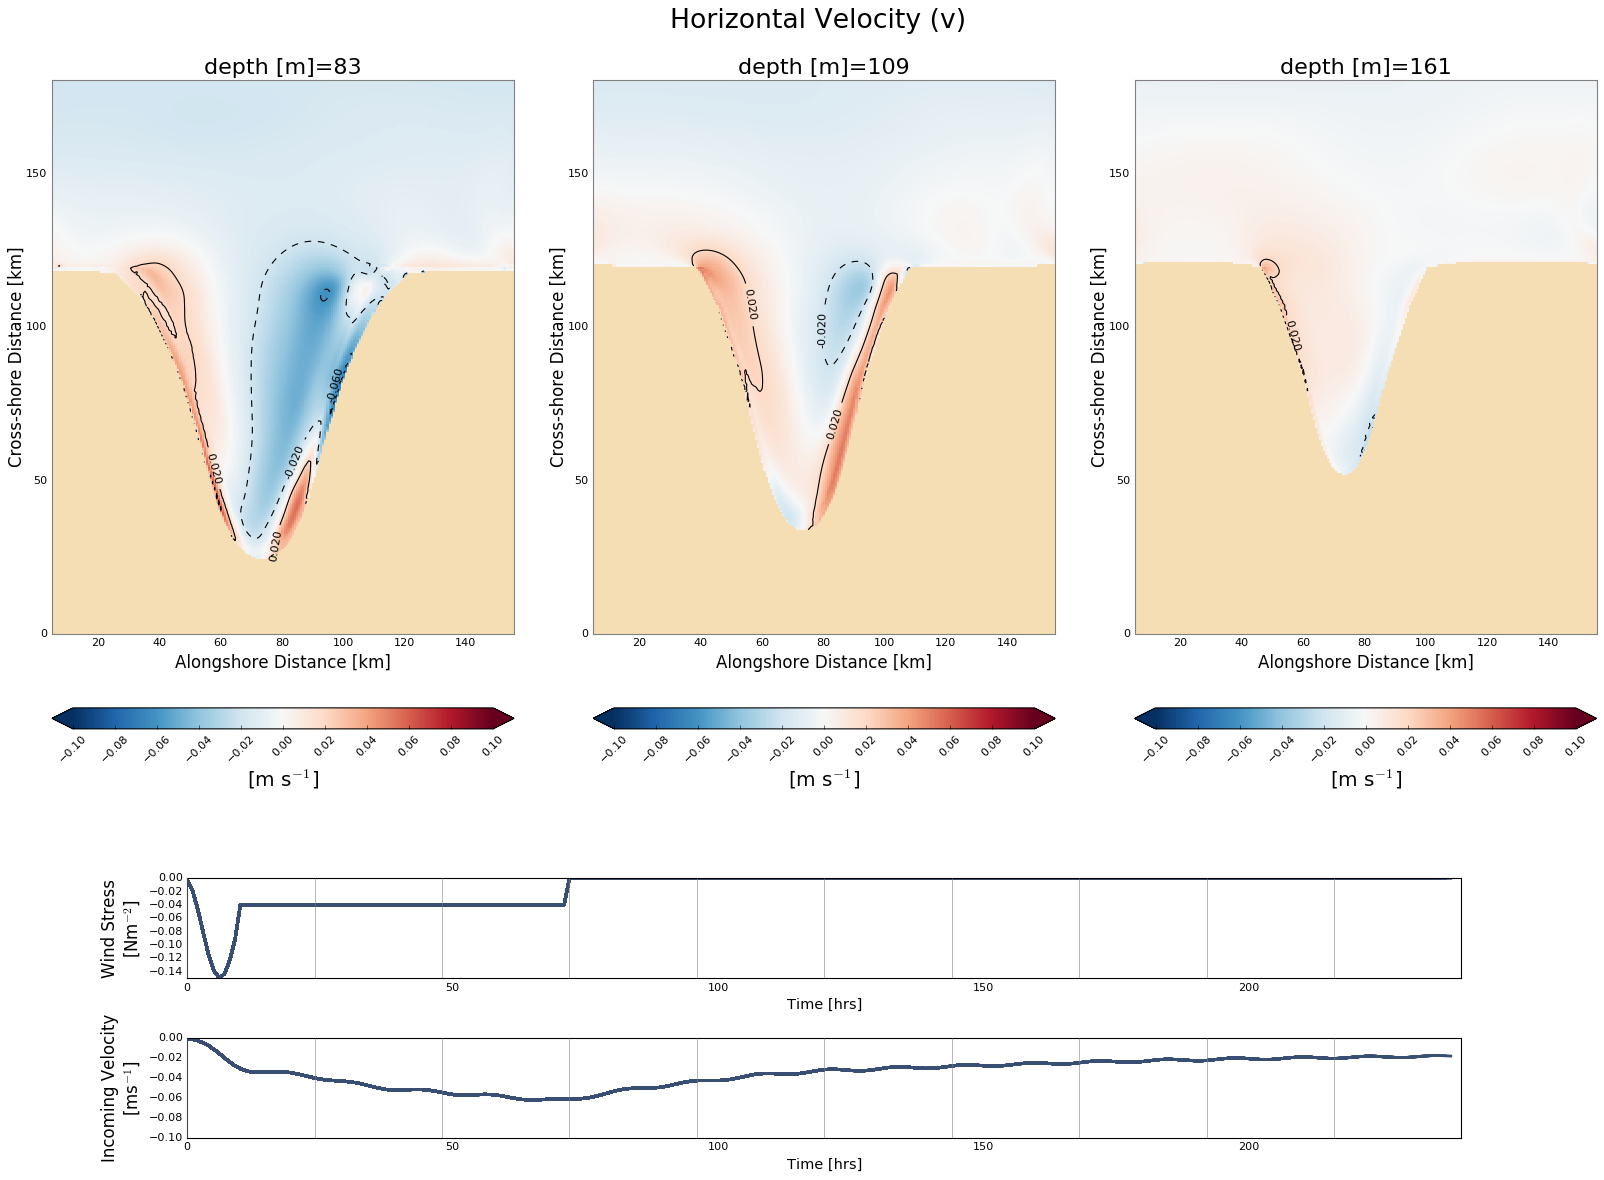

In [14]:
fig = plt.figure(figsize=(20, 15))
ax1 = plt.subplot2grid((7, 12), (0, 0), colspan=4, rowspan=5)
ax2 = plt.subplot2grid((7, 12), (0, 4), colspan=4, rowspan=5, sharey=ax1)
ax3 = plt.subplot2grid((7, 12), (0, 8), colspan=4, rowspan=5, sharey=ax1)
axa = plt.subplot2grid((7, 12), (5, 1), colspan=10, rowspan=1)
axb = plt.subplot2grid((7, 12), (6, 1), colspan=10, rowspan=1)

axes = [ax1, ax2, ax3]
fig, axes, axa, axb = general_functions.set_plots(fig, axes, axa, axb, 'Horizontal Velocity (v)')
vm_min, vm_max, levels = general_functions.get_limits(vomecrtyA, vomecrtyB, vomecrtyC, 0.4, 6, 'vel')

print(vm_min, vm_max, levels)

Writer = animation.writers['ffmpeg']
writer = Writer(fps=3, bitrate=1000000, codec="libx264")
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=10*24)
anim.save('vvel_panels.mp4', writer=writer)